## 参考资料：

* [DeepWalk代码实战-维基百科词条图嵌入可视化（同济子豪兄）](https://www.bilibili.com/video/BV1et4y187Gd/?spm_id_from=333.788&vd_source=36e948dc2acdb36d7055f879d377b529)


## 导入工具包

In [1]:
import networkx as nx # 图数据挖掘

# 数据分析
import pandas as pd
import numpy as np

import random # 随机数
from tqdm import tqdm # 进度条库

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

## 获取维基百科网页引用关联数据


1.打开网站`https://densitydesign.github.io/strumentalia-seealsology`

2.Distance设置为`4`

3.输入以下链接

https://en.wikipedia.org/wiki/Computer_vision

https://en.wikipedia.org/wiki/Deep_learning

https://en.wikipedia.org/wiki/Convolutional_neural_network

https://en.wikipedia.org/wiki/Decision_tree

https://en.wikipedia.org/wiki/Support-vector_machine

4.点击`START CRAWLING`，爬取1000个网页之后，点击`STOP & CLEAR QUEUE`

5.Download-下载TSV文件，保存至代码相同目录，命名为`seealsology-data.tsv`

In [2]:
df = pd.read_csv("seealsology-data.tsv", sep = "\t")

In [3]:
df.head()

,source,target,depth
0,support-vector machine,in situ adaptive tabulation,1
1,support-vector machine,kernel machines,1
2,support-vector machine,fisher kernel,1
3,support-vector machine,platt scaling,1
4,support-vector machine,polynomial kernel,1


In [4]:
df.shape

(13211, 3)

## 构建无向图

In [5]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [6]:
# 节点个数
len(G)

8560

## 生成随机游走节点序列的函数

In [7]:
## 随机游走
def get_randomwalk(node, path_length):
    '''
    输入起始节点和路径长度，生成随机游走节点序列
    '''
    random_walk = [node]
    
    for i in range(path_length-1):
        # 汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        # 从邻接节点中随机选择下一个节点
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [8]:
all_nodes = list(G.nodes())

In [9]:
all_nodes

['support-vector machine',
 'in situ adaptive tabulation',
 'kernel machines',
 'fisher kernel',
 'platt scaling',
 'polynomial kernel',
 'predictive analytics',
 'regularization perspectives on support-vector machines',
 'relevance vector machine',
 'sequential minimal optimization',
 'space mapping',
 'winnow (algorithm)',
 'decision tree',
 'behavior tree (artificial intelligence, robotics and control)',
 'boosting (machine learning)',
 'decision cycle',
 'decision list',
 'decision matrix',
 'decision table',
 'decision tree model',
 'design rationale',
 'drakon',
 'markov chain',
 'random forest',
 'odds algorithm',
 'topological combinatorics',
 'truth table',
 'convolutional neural network',
 'attention (machine learning)',
 'convolution',
 'deep learning',
 'natural-language processing',
 'neocognitron',
 'scale-invariant feature transform',
 'time delay neural network',
 'vision processing unit',
 'applications of artificial intelligence',
 'comparison of deep learning softwar

In [10]:
get_randomwalk('random forest', 8)

['random forest',
 'boosting (meta-algorithm)',
 'bootstrap aggregating',
 'random subspace method',
 'out-of-bag error',
 'bootstrapping (statistics)',
 'reliability (statistics)',
 'interval finite element']

## 生成随机游走序列

In [11]:
gamma = 10 # 每个节点作为起始点生成随机游走序列个数
walk_length = 8 # 随机游走序列最大长度

In [12]:
random_walks = []

for n in tqdm(all_nodes): # 遍历每个节点
    for i in range(gamma): # 每个节点作为起始点生成gamma个随机游走序列
        random_walks.append(get_randomwalk(n, walk_length))

100%|██████████| 8560/8560 [00:00<00:00, 9966.91it/s] 


In [13]:
# 生成随机游走序列个数
len(random_walks)

85600

In [14]:
random_walks[1]

['support-vector machine',
 'kernel machines',
 'support vector machine',
 'fisher kernel',
 'fisher information metric',
 'fisher information',
 'kullback–leibler divergence',
 'maximum entropy thermodynamics']

## 训练Word2Vec模型（Skip-Gram）

In [15]:
from gensim.models import Word2Vec # 自然语言处理

In [16]:
model = Word2Vec(vector_size=128, # Embedding维数
                 window=3, # 窗口宽度
                 sg=1, # 采用Skip-Gram
                 hs=0, # 不加分层softmax
                 negative=10, # 负采样
                 alpha=0.03,  # 初始学习率
                 min_alpha=0.0007, # 最小学习率
                 seed=14 # 随机数种子
                )

In [17]:
# 用随机游走序列构建词汇表
model.build_vocab(random_walks, progress_per=2)

In [18]:
model.corpus_count

85600

In [19]:
# 训练（耗时1分钟左右）
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

(19539006, 19539650)

## 分析Word2Vec结果

In [20]:
# 查看某个节点的Embedding
model.wv.get_vector('random forest').shape

(128,)

In [21]:
model.wv.get_vector('random forest')

array([-0.23928453,  0.14539061,  0.6244226 ,  0.3926265 , -1.0033873 ,
        0.35190976,  0.03118012,  0.30006078, -0.07584476,  0.03681907,
       -0.15682864, -0.10018766,  0.03830915, -0.51739836, -0.38856518,
       -0.04252914,  0.16454647,  0.09492868, -0.40716204, -0.36076927,
        0.6718606 ,  0.74670786,  0.29593894,  0.301656  ,  0.10927553,
       -1.1252604 ,  0.25917804,  0.9691724 ,  0.02610298, -0.62601465,
       -0.3312412 , -0.22638477, -0.4926442 , -0.7447466 ,  0.73460984,
        0.4682642 , -0.1375747 , -0.3442499 , -0.36722696, -0.27256438,
        0.55493575, -0.01926724,  0.20779975, -0.19849852, -0.61865187,
       -0.04388637,  0.69324917, -0.0224314 , -0.47522348,  0.05983894,
       -0.5619074 , -0.33399987, -0.124885  , -0.02532075, -0.15551682,
        0.61554575, -0.33532003,  0.48784882, -0.6213515 , -0.43253645,
       -0.73426473, -0.01506333,  0.6373057 ,  0.9603933 ,  0.61642224,
        0.521132  ,  0.37309095, -0.3381873 , -0.37943637, -0.52

In [22]:
# 找相似词语
model.wv.similar_by_word('decision tree')

[('drakon', 0.7445662021636963),
 ('decision list', 0.7226133942604065),
 ('behavior trees (artificial intelligence, robotics and control)',
  0.6879785060882568),
 ('self-documenting code', 0.6549766659736633),
 ('pseudocode', 0.648777425289154),
 ('goal structuring notation', 0.6437751054763794),
 ('decision matrix', 0.6343960762023926),
 ('behavior tree (artificial intelligence, robotics and control)',
  0.633910059928894),
 ('comparison sort', 0.6311823725700378),
 ('random forest', 0.6163313984870911)]

## PCA降维可视化

### 可视化全部词条的二维Embedding

In [23]:
X = model.wv.vectors

In [24]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

In [25]:
embed_2d.shape

(8560, 2)

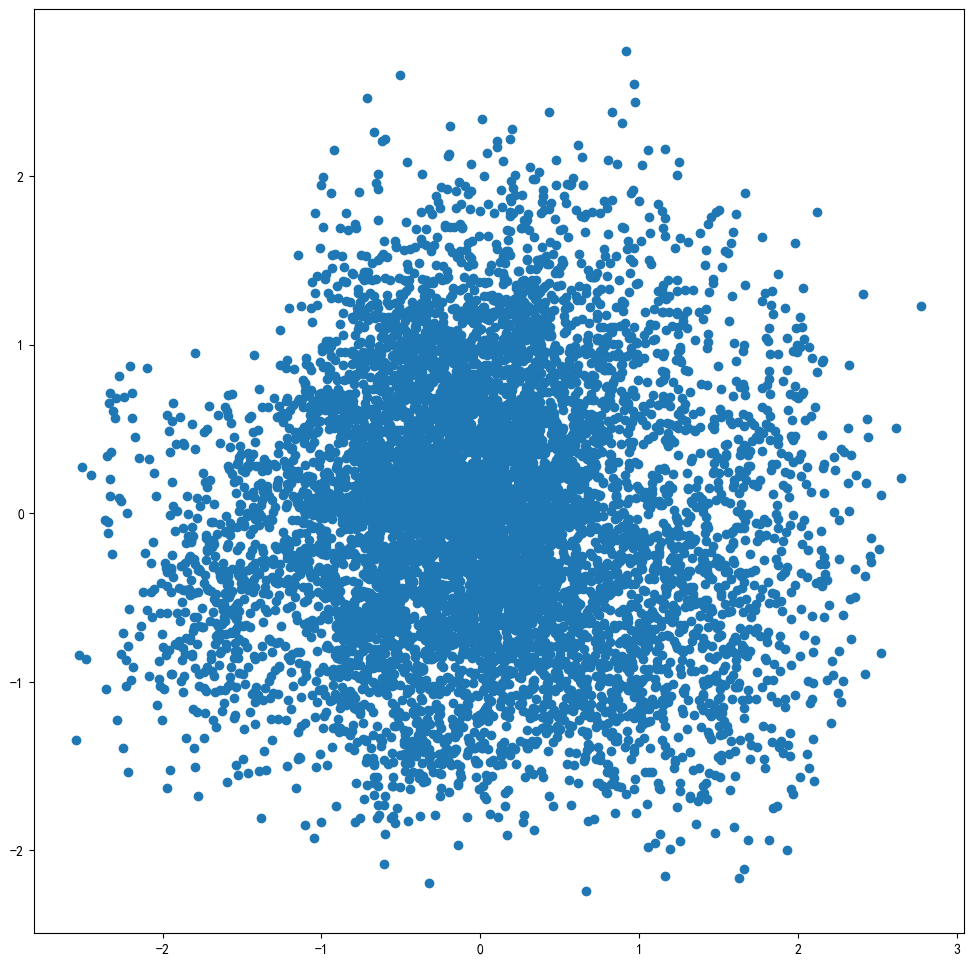

In [26]:
plt.figure(figsize=(12,12))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

### 可视化某个词条的二维Embedding

In [27]:
term = 'computer vision'

In [28]:
term_256d = model.wv[term].reshape(1,-1)

In [29]:
term_256d.shape

(1, 128)

In [30]:
term_2d = pca.transform(term_256d)

In [31]:
term_2d

array([[0.46472865, 0.82896155]], dtype=float32)

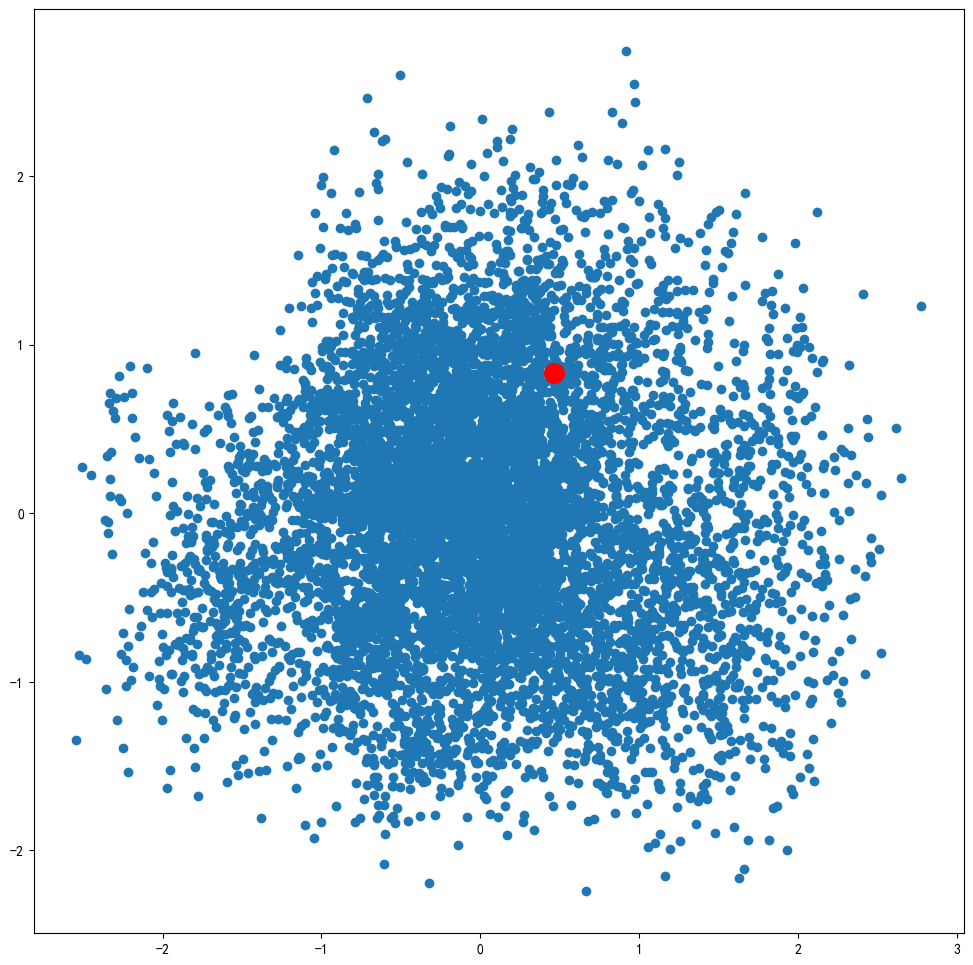

In [32]:
plt.figure(figsize=(12,12))
plt.scatter(embed_2d[:,0], embed_2d[:,1])
plt.scatter(term_2d[:,0],term_2d[:,1],c='r',s=200)
plt.show()

### 可视化某些词条的二维Embedding

In [33]:
# 计算PageRank重要度
pagerank = nx.pagerank(G)
# 从高到低排序
node_importance = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

In [34]:
# 取最高的前n个节点
n = 30
terms_chosen = []
for each in node_importance[:n]:
    terms_chosen.append(each[0])

In [35]:
# 手动补充新节点
terms_chosen.extend(['computer vision','deep learning','convolutional neural network','convolution','natural-language processing','attention (machine learning)','support-vector machine','decision tree','random forest','computational imaging','machine vision','cognitive science','neuroscience','psychophysics','brain','visual cortex','visual neuroscience','cognitive model','finite difference','finite difference time domain','finite difference coefficients','finite difference methods for option pricing','iso 128','iso 10303'])

In [36]:
terms_chosen

['graph theory',
 'chaos theory',
 'claude shannon',
 'information theory',
 'operations research',
 'quantum logic gate',
 'data mining',
 'remote sensing',
 'electromagnetic wave equation',
 'collective intelligence',
 'control theory',
 'fourier transform',
 'empathy',
 'false dilemma',
 'simulated reality',
 'superlens',
 'digital preservation',
 'wearable computer',
 'low-density parity-check code',
 'analytics',
 'spatial dependence',
 'constructed language',
 'correlation',
 'semantic web',
 'psychoacoustics',
 'collaborative software',
 'philosophy of perception',
 'cognitive science',
 'transhumanism',
 'self-awareness',
 'computer vision',
 'deep learning',
 'convolutional neural network',
 'convolution',
 'natural-language processing',
 'attention (machine learning)',
 'support-vector machine',
 'decision tree',
 'random forest',
 'computational imaging',
 'machine vision',
 'cognitive science',
 'neuroscience',
 'psychophysics',
 'brain',
 'visual cortex',
 'visual neurosci

In [37]:
# 输入词条，输出词典中的索引号
term2index = model.wv.key_to_index

In [38]:
# index2term = model.wv.index_to_key
# term_index = np.array(term2index.values())

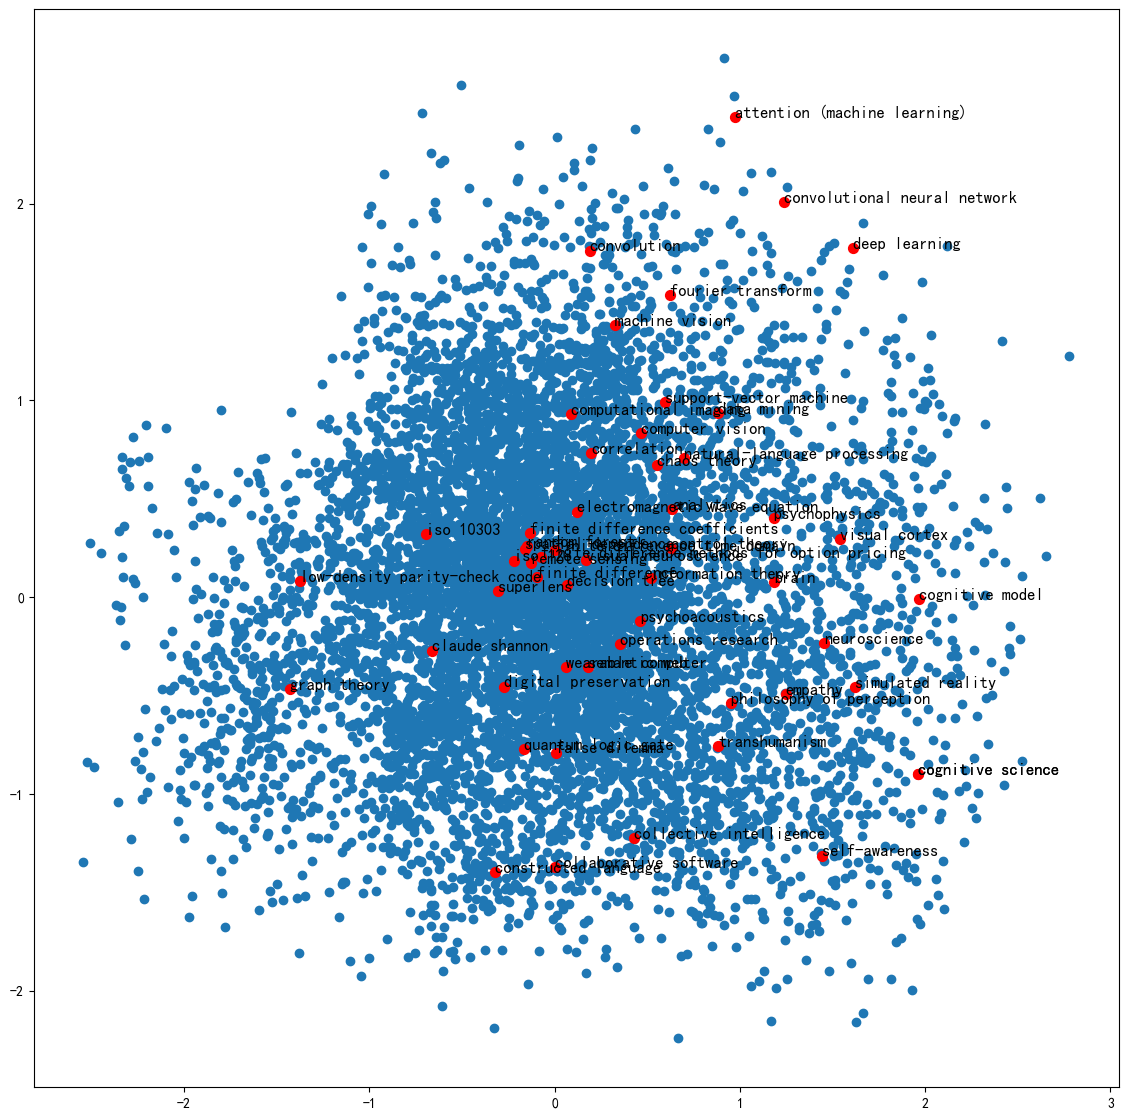

In [39]:
# 可视化全部词条和关键词条的二维Embedding
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=12)
plt.show()

## TSNE降维可视化

### 可视化全部词条的二维Embedding¶

In [40]:
# 将Embedding用TSNE降维到2维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

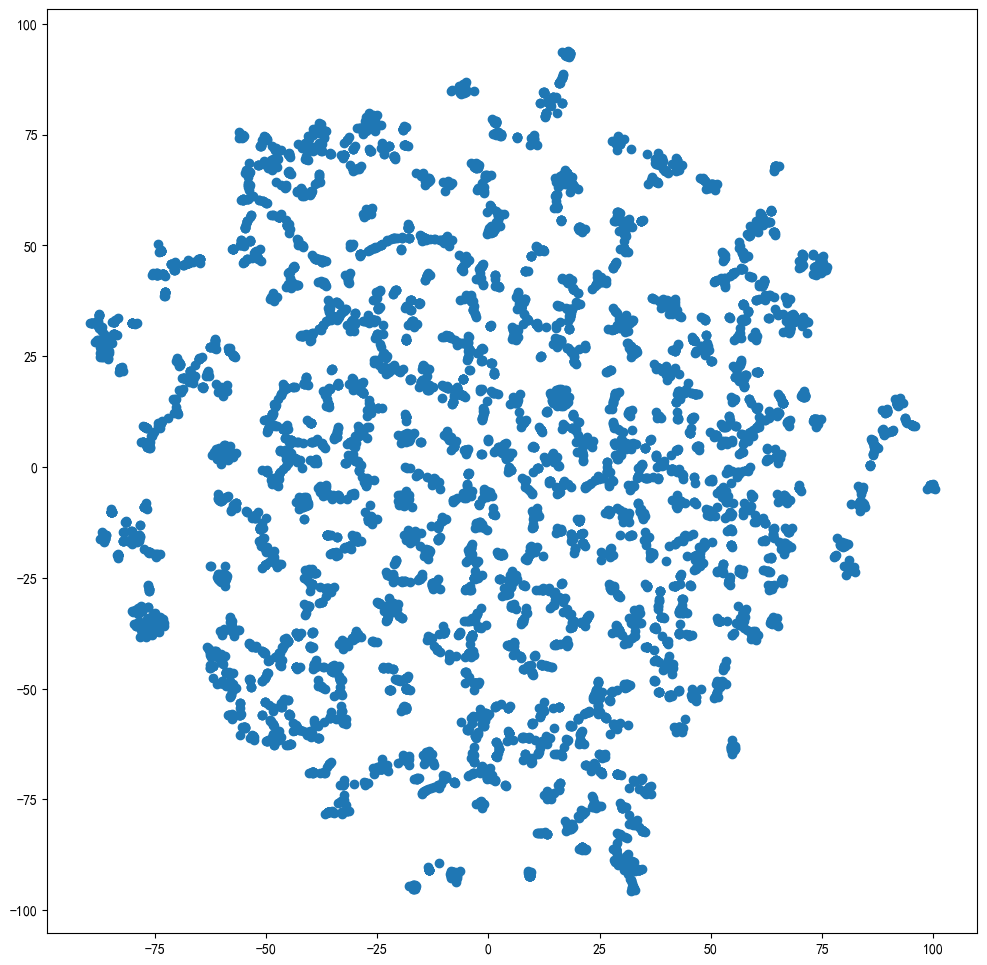

In [41]:
plt.figure(figsize=(12,12))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

### 可视化全部词条和关键词条的二维Embedding

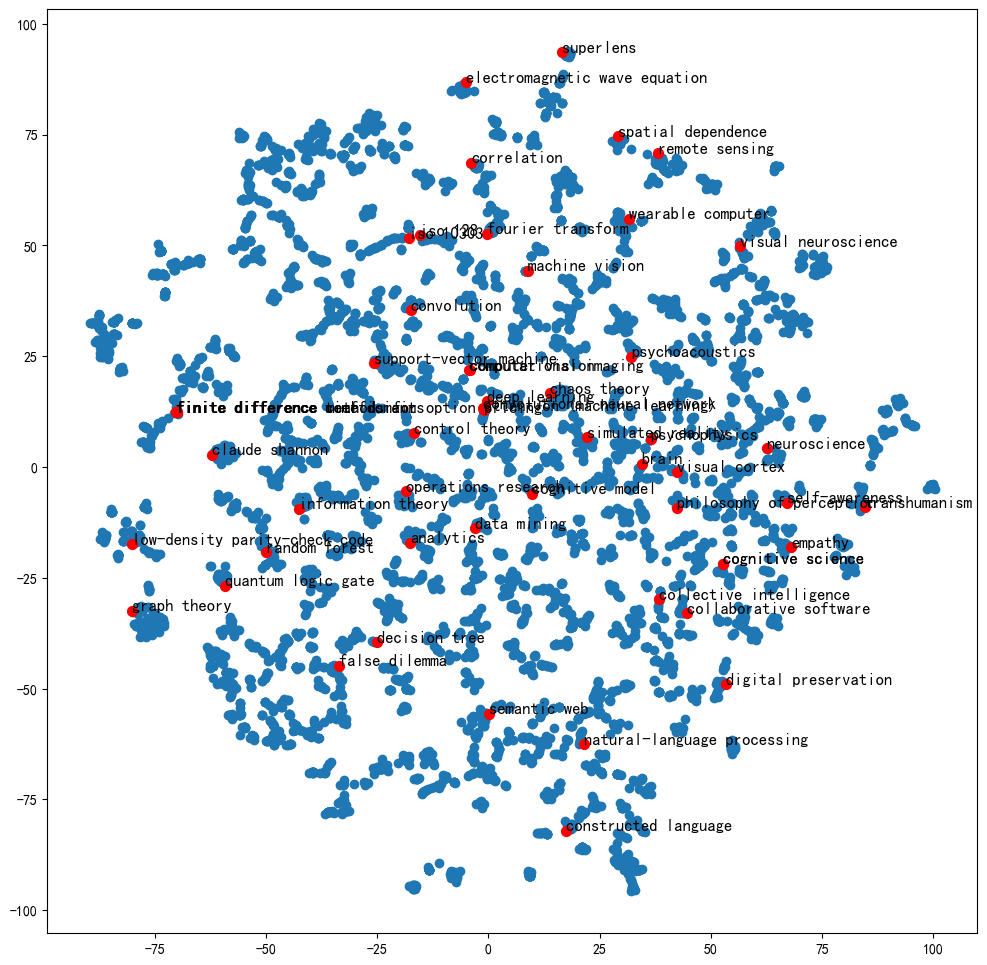

In [42]:
plt.figure(figsize=(12,12))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=12)
plt.show()

In [43]:
embed_2d.shape

(8560, 2)

### 导出TSNE降维到二维之后的Embedding

In [44]:
terms_chosen_mask = np.zeros(X.shape[0])
for item in terms_chosen:
    idx = term2index[item]
    terms_chosen_mask[idx] = 1

In [45]:
df = pd.DataFrame()
df['X'] = embed_2d[:,0]
df['Y'] = embed_2d[:,1]
df['item'] = model.wv.index_to_key
df['pagerank'] = pagerank.values()
df['chosen'] = terms_chosen_mask

In [46]:
df

,X,Y,item,pagerank,chosen
0,-80.114120,-32.432236,graph theory,0.000289,1.0
1,-42.653564,-9.367265,information theory,0.000185,1.0
2,-2.978273,-13.760601,data mining,0.000173,1.0
3,-62.219643,2.789460,claude shannon,0.000091,1.0
4,-16.810465,7.690732,control theory,0.000083,1.0
...,...,...,...,...,...
8555,-36.443855,-27.334448,malthusian growth model,0.000050,0.0
8556,83.520538,-8.105978,respirocyte,0.000051,0.0
8557,30.456234,54.636147,pocket computer,0.000051,0.0
8558,79.393646,-17.548584,hylozoism,0.000047,0.0


In [47]:
df.to_csv('tsne_vis_2d.csv',index=False)